In [100]:
%pip install torch numpy pandas matplotlib pytorch-lightning librosa


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [101]:
# imports
import torch
import torch.nn as nn
import librosa
import matplotlib.pyplot as plt
import numpy as np
from torch import Tensor
from torch.utils.data import DataLoader, Dataset
import typing

# Project Overview and Motivation

### Modeling Effects Pedals

Since the 1950s, guitarists and other instrumentalists have used effects pedals to achieve certain sounds from their instruments, from overdrive and distortion to reverb and delay. These effects are often encapsulated in physical pedals, each one with different analog circuitry, down to the types of capacitors that go on the pedals, to achieve these different sounds. Musicians will then use these pedals downstream of their instrument signal to apply the effect.

Here is a common signal flow for an overdrive pedal with a guitar:

![signal flow](images/signal-flow.png "Signal Flow")

The guitar produces an input signal, which goes through the overdrive pedal, applying the overdriven effect (a sound that is more distorted and louder) on the raw signal, which then goes through the amplifier, which applies its own sound, and outputs it over its speakers.

### Creating An Effects Pedal Model

Now, the goal of this project is to use machine learning to replace the pedal in the signal chain with software -- a model that emulates the same sound that musicians come to expect when using that pedal.

![signal flow in software](images/signal-flow-sw.png "Signal Flow in Software")

Using an input waveform from the guitar, and an output waveform from the guitar pedal, we can perform supervised learning to achieve this pedal model, completely cutting out the physical pedal in the signal chain altogether!

### Our Setup

For this project, we wanted to model a Boss DS-2 Turbo Distortion Pedal. To achieve this setup and record our dataset, we split the output of the guitar -- one side goes into an input of an audio interface so we can record the raw guitar signal, and the other goes to the pedal, the output of which goes to another input of the audio interface so we can record the distorted guitar signal.


## Analyze audio signals
Our first step is to actually analyze our audio signals. We can use librosa, a package for audio analysis, for this task. What we are essentially doing here is reading from our .wav files and plotting that data on a graph which depicts the amplitude of the wave over time.

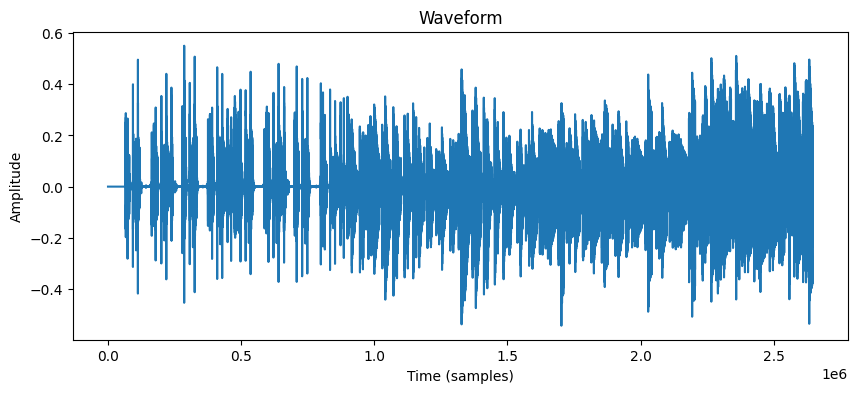

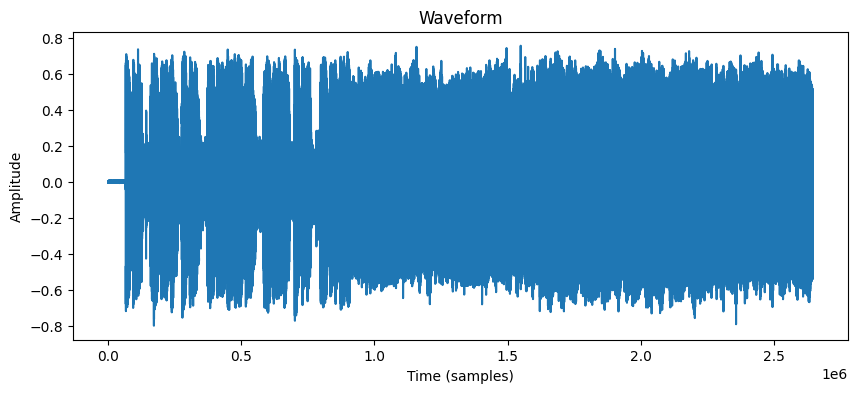

In [102]:
# data exploration to expand on later

def load_audio(file_path: str) -> tuple:
    audio_signal, sampling_rate = librosa.load(file_path, sr=None)
    return audio_signal, sampling_rate

def plot_waveform(wave: np.ndarray) -> None:
    # Plot the waveform
    plt.figure(figsize=(10, 4))
    plt.plot(wave)
    plt.title("Waveform")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()

# inp_audio_signal, inp_sampling_rate = load_audio("./data/ML_Pedal_Input.wav")
# out_audio_signal, out_sampling_rate = load_audio("./data/ML_Pedal_Output.wav")

# Downsampled audio signals
# inp_audio_signal, inp_sampling_rate = load_audio("./data/ML_Pedal_Input_DS.wav")
# out_audio_signal, out_sampling_rate = load_audio("./data/ML_Pedal_Output_DS.wav")

inp_audio_signal, inp_sampling_rate = load_audio("./ht1-input.wav")
out_audio_signal, out_sampling_rate = load_audio("./ht1-target.wav")


# Make signal divisible by sample rate
inp_audio_signal = inp_audio_signal[:-(len(inp_audio_signal) % inp_sampling_rate)]
out_audio_signal = out_audio_signal[:-(len(out_audio_signal) % out_sampling_rate)]

# One minute of audio
inp_audio_signal = inp_audio_signal[:inp_sampling_rate * 60]
out_audio_signal = out_audio_signal[:out_sampling_rate * 60]

plot_waveform(inp_audio_signal)
plot_waveform(out_audio_signal)

### Analysis
as can be seen here, the graph for input and output datasets differ drastically

# Machine Learning
We are planning on using a neural network for our machine learning model. 

In [103]:
# turn into tensors for torch

def to_tensor(data: np.ndarray) -> torch.Tensor:
    return torch.tensor(data, dtype=torch.float32).unsqueeze(1)

inp_tensor = to_tensor(inp_audio_signal)
out_tensor = to_tensor(out_audio_signal)

print(f"Input Tensor Shape: {inp_tensor.shape}")
print(f"Target Tensor Shape: {out_tensor.shape}")

Input Tensor Shape: torch.Size([2646000, 1])
Target Tensor Shape: torch.Size([2646000, 1])


## Neural Network
WaveNet is our initial neural network for this project. There are five layers in this model, and we will explain our reasoning for using these five layers shortly
1. Input Layer
    - this is our input layer that takes in our raw audio signal and converts it via a 1x1 convolution, which transforms a single-channel raw waveform into multiple feature maps. Feature maps are the output of the 1x1 convolution that lets the model decide which features actually matter (pitch, amplitude, etc.). This makes it so that we do not have to manually select our features, which, due to the vast domain of audio, could lead our model to be overfitted.
2. Dilated Convolution Layers:
3. Residual Connections
4. Skip Connections
5. Output Layer


In [104]:
cuda_available = torch.cuda.is_available()

device = torch.device("cuda" if cuda_available else "cpu")

print(f"Device: {device}")

Device: cuda


In [105]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(ResidualBlock, self).__init__()
        padding = dilation * (kernel_size - 1)
        self.dilated_conv = nn.Conv1d(
            in_channels, out_channels, kernel_size, dilation=dilation, padding=padding
        )
        self.skip_conv = nn.Conv1d(out_channels, out_channels, 1)
        self.residual_conv = nn.Conv1d(out_channels, in_channels, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        out = self.dilated_conv(x)
        skip = self.skip_conv(out)
        residual = self.residual_conv(out)
        out = self.activation(out + skip)  # Add residual + skip, then apply activation
        return out, residual


class WaveNet(nn.Module):
    def __init__(
        self,
        num_channels: int = 32,
        dilation_depth: int = 4,
        kernel_size: int = 2,
        num_classes: int = 256,
    ):
        super(WaveNet, self).__init__()
        self.input_layer = nn.Conv1d(
            in_channels=1, out_channels=num_channels, kernel_size=1
        )

        self.residual_blocks = nn.ModuleList()
        dilation = 1
        for i in range(dilation_depth):
            self.residual_blocks.append(
                ResidualBlock(num_channels, num_channels, kernel_size, dilation)
            )
            dilation *= 2  # Double the dilation at each block

        self.output_layer = nn.Conv1d(num_channels, 1, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = self.input_layer(x)
        skip_connections = []
        for block in self.residual_blocks:
            out, skip = block(out)
            # skip_connections.append(skip)

            # # Ensure the skip connections have the same shape
            # out = sum(skip_connections)  # Sum over the skip connections
        out = self.output_layer(out)
        return out

In [106]:
batch_size = 128
learning_rate = 0.001
num_epochs = 100

num_channels = 32
dilation_depth = 4
kernel_size = 2
num_classes = 2 ** 8

In [107]:
def train_model(model: nn.Module, dataLoader: DataLoader, criterion: nn.Module, optimizer: torch.optim.Optimizer, num_epochs: int = 10) -> None:
    model.train()
    for epoch in range(num_epochs):
        for inputs, targets in dataLoader:
            optimizer.zero_grad()

            inputs = inputs.unsqueeze(1)
            targets = targets.unsqueeze(1)

            outputs = model(inputs)

            loss = criterion(outputs, targets)

            loss.backward()
            optimizer.step()
        print(f"Epoch: {epoch + 1}, Loss: {loss.item()}")

In [108]:
# training loop

# class for pytorch
class Audio(Dataset):
    def __init__(self, inputs: Tensor, outputs: Tensor):
        self.inputs = inputs
        self.outputs = outputs

    def __len__(self) -> int:
        return len(self.inputs)

    def __getitem__(self, index: int) -> tuple:
        return self.inputs[index], self.outputs[index]

model = WaveNet(num_channels, dilation_depth, kernel_size, num_classes)

# inp_tensor = inp_tensor.to(device)
# out_tensor = out_tensor.to(device)
# model = model.to(device)

# training_dataset = Audio(inp_tensor, out_tensor)
# train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)

# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Load model
# model.load_state_dict(torch.load("wavenet_guitar_model.pth"))

# train_model(model, train_loader, criterion, optimizer, num_epochs)


In [109]:
torch.save(model.state_dict(), "wavenet_guitar_model.pth")
print("Model saved successfully.")

Model saved successfully.


In [110]:
model = WaveNet()  # Ensure this matches the architecture used during training

# Load the saved state dictionary
model.load_state_dict(torch.load("wavenet_guitar_model.pth"))
model.eval()  # Set the model to evaluation mode
print("Model loaded successfully.")

Model loaded successfully.


/tmp/ipykernel_124167/76303354.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("wavenet_guitar_model.pth"))


In [111]:
# ESR loss calculates the Error-to-signal between the output/target
class ESRLoss(nn.Module):
    def __init__(self):
        super(ESRLoss, self).__init__()
        self.epsilon = 0.00001

    def forward(self, output, target):
        loss = torch.add(target, -output)
        loss = torch.pow(loss, 2)
        loss = torch.mean(loss)
        energy = torch.mean(torch.pow(target, 2)) + self.epsilon
        loss = torch.div(loss, energy)
        return loss

In [112]:
import torch
import torch.nn as nn
import math
from torch.utils.data import DataLoader, Dataset

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, hidden):
        super(SimpleLSTM, self).__init__()
        self.output_size = output_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=0.2)
        self.last_layer = nn.Linear(hidden_size, output_size, bias=True)
        self.skip = 1
        self.hidden = hidden

    # def forward(self, x: torch.Tensor) -> torch.Tensor:
    #     # save residual for skip
    #     if self.skip:
    #         # res = x[:, :, 0:self.skip]
    #         res = x
    #     output, self.hidden = self.lstm(x, self.hidden)
    #     output = self.last_layer(output)
    #     return output

    def forward(self, x):
        if self.skip:
            # save the residual for the skip connection
            res = x[:, :, 0:self.skip]
            x, self.hidden = self.lstm(x, self.hidden)
            return self.last_layer(x) + res
        else:
            x, self.hidden = self.lstm(x, self.hidden)
            return self.last_layer(x)

    # def train_epoch(self, data_loader: DataLoader, criterion: nn.Module, optimizer: torch.optim.Optimizer, init_len: int = 64, up_fr: int = 1000) -> float:
    #     total_loss = 0.0
    #     for inputs, targets in data_loader:
    #         init_inputs = inputs[0:init_len:, :, :]
    #         rest_inputs = inputs[init_len:, :, : ]
    #         rest_targets = targets[init_len:, :, :]

    #         self(init_inputs)
    #         self.zero_grad()

    #         # Ensure inputs and targets are on the same device as the model
    #         start_i = init_len
    #         batch_loss = 0

    #         window_iterations = math.ceil(len(rest_inputs) / up_fr)
    #         for i in range(window_iterations):
    #             inputs = rest_inputs[start_i:start_i + up_fr, :, :]
    #             targets = rest_targets[start_i:start_i + up_fr, :, :]

    #             inputs = inputs.to(device).contiguous()
    #             targets = targets.to(device).contiguous()

    #             outputs = self(inputs)
    #             loss = criterion(outputs, targets)

    #             loss.backward()
    #             optimizer.step()

    #             self.detach_hidden()
    #             self.zero_grad()

    #             batch_loss += loss
    #             start_i += up_fr

    #         total_loss += batch_loss / window_iterations if window_iterations > 0 else 0
    #         self.reset_hidden()

    #     return total_loss / len(data_loader)

    def train_epoch(self, input_data, target_data, loss_fcn, optim, bs, init_len=200, up_fr=1000):
        # shuffle the segments at the start of the epoch
        shuffle = torch.randperm(input_data.shape[1])

        # Iterate over the batches
        ep_loss = 0
        for batch_i in range(math.ceil(shuffle.shape[0] / bs)):
            # Load batch of shuffled segments
            input_batch = input_data[:, shuffle[batch_i * bs:(batch_i + 1) * bs], :]
            target_batch = target_data[:, shuffle[batch_i * bs:(batch_i + 1) * bs], :]

            # Initialise network hidden state by processing some samples then zero the gradient buffers
            self(input_batch[0:init_len, :, :])
            self.zero_grad()

            # Choose the starting index for processing the rest of the batch sequence, in chunks of args.up_fr
            start_i = init_len
            batch_loss = 0
            # Iterate over the remaining samples in the mini batch
            for k in range(math.ceil((input_batch.shape[0] - init_len) / up_fr)):
                # Process input batch with neural network
                output = self(input_batch[start_i:start_i + up_fr, :, :])

                # Calculate loss and update network parameters
                loss = loss_fcn(output, target_batch[start_i:start_i + up_fr, :, :])
                loss.backward()
                optim.step()

                # Set the network hidden state, to detach it from the computation graph
                self.detach_hidden()
                self.zero_grad()

                # Update the start index for the next iteration and add the loss to the batch_loss total
                start_i += up_fr
                batch_loss += loss

            # Add the average batch loss to the epoch loss and reset the hidden states to zeros
            ep_loss += batch_loss / (k + 1)
            self.reset_hidden()
        return ep_loss / (batch_i + 1)


    # detach hidden state, this resets gradient tracking on the hidden state
    def detach_hidden(self):
        if self.hidden.__class__ == tuple:
            self.hidden = tuple([h.clone().detach() for h in self.hidden])
        else:
            self.hidden = self.hidden.clone().detach()

    # changes the hidden state to None, causing pytorch to create an all-zero hidden state when the rec unit is called
    def reset_hidden(self):
        h_0 = torch.zeros(1, 1, self.hidden_size).to(device)
        c_0 = torch.zeros(1, 1, self.hidden_size).to(device)
        self.hidden = (h_0, c_0)

    def save_model(self, path: str) -> None:
        torch.save(self.state_dict(), path)
        print("Model saved successfully.")

    def load_model(self, path: str) -> None:
        self.load_state_dict(torch.load(path))

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        model.eval()

        # Reshape input tensor to LSTM input shape
        x = x.unsqueeze(1)

        with torch.no_grad():
            return self(x)

In [113]:
num_classes = 1
input_size = num_classes
output_size = input_size
batch_size = 128
init_len = 200
up_fr = 1000
hidden_size = 16
num_layers = 1
num_epochs = 1000
learning_rate = 0.005
reload_model = False

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize hidden state
h_0 = torch.zeros(1, 1, hidden_size).to(device).contiguous()
c_0 = torch.zeros(1, 1, hidden_size).to(device).contiguous()

# Model
lstm_model = SimpleLSTM(input_size, output_size, hidden_size, num_layers, (h_0, c_0)).to(device)

if reload_model:
    lstm_model.load_model("lstm_guitar_model.pth")

# Training loop
criterion = ESRLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Assuming inp_tensor and out_tensor are already defined
inp_tensor_lstm = inp_tensor.unsqueeze(1).to(device).contiguous()
out_tensor_lstm = out_tensor.unsqueeze(1).to(device).contiguous()

print(f"Input Tensor Shape: {inp_tensor_lstm.shape}")
print(f"Target Tensor Shape: {out_tensor_lstm.shape}")

training_dataset = list(zip(inp_tensor_lstm, out_tensor_lstm))
dataloader = DataLoader(training_dataset, batch_size=batch_size)

save_epoch_interval = 10
save_model = True

print("Hyperparameters:")
print(f"Batch Size: {batch_size}")
print(f"Learning Rate: {learning_rate}")
print(f"Number of Epochs: {num_epochs}")
print(f"Hidden Size: {hidden_size}")
print(f"Number of Layers: {num_layers}")
print(f"Update Frequency: {up_fr}")
print(f"Save Model: {save_model}")

lstm_model.train()
for epoch in range(num_epochs):
    if epoch % save_epoch_interval and save_model == 0:
        lstm_model.save_model("lstm_guitar_model.pth")

    batch = next(iter(dataloader))

    # loss = lstm_model.train_epoch(dataloader, criterion, optimizer, init_len=50, up_fr=up_fr)
    loss = lstm_model.train_epoch(inp_tensor_lstm, out_tensor_lstm, criterion, optimizer, batch_size, init_len=init_len, up_fr=up_fr)
    lstm_model.reset_hidden()
    # scheduler.step()
    print(f"Epoch: {epoch + 1} Loss: {loss} LR: {optimizer.param_groups[0]['lr']}")

Input Tensor Shape: torch.Size([2646000, 1, 1])
Target Tensor Shape: torch.Size([2646000, 1, 1])
Hyperparameters:
Batch Size: 128
Learning Rate: 0.005
Number of Epochs: 1000
Hidden Size: 16
Number of Layers: 1
Update Frequency: 1000
Save Model: True
Epoch: 1 Loss: 3.2689971923828125 LR: 0.005
Epoch: 2 Loss: 0.9261032938957214 LR: 0.005
Epoch: 3 Loss: 1.0617307424545288 LR: 0.005
Epoch: 4 Loss: 0.8978807926177979 LR: 0.005
Epoch: 5 Loss: 1.3582836389541626 LR: 0.005
Epoch: 6 Loss: 0.8552202582359314 LR: 0.005
Epoch: 7 Loss: 1.8000481128692627 LR: 0.005
Epoch: 8 Loss: 0.8511890769004822 LR: 0.005
Epoch: 9 Loss: 0.934259831905365 LR: 0.005
Epoch: 10 Loss: 0.9375752210617065 LR: 0.005
Epoch: 11 Loss: 2.6587319374084473 LR: 0.005
Epoch: 12 Loss: 0.7173973917961121 LR: 0.005
Epoch: 13 Loss: 5.6162190437316895 LR: 0.005
Epoch: 14 Loss: 1.93308424949646 LR: 0.005
Epoch: 15 Loss: 0.7645654082298279 LR: 0.005
Epoch: 16 Loss: 2.2461180686950684 LR: 0.005
Epoch: 17 Loss: 0.8919165730476379 LR: 0.0

KeyboardInterrupt: 

In [ ]:
inputs, targets = one_batch

# Predict
outputs = lstm_model.predict(inputs.squeeze(1).to(device))

print(f"Inputs {inputs[:10]}")

print(f"Outputs {outputs[:10]}")

print(f"Targets {targets[:10]}")

Inputs tensor([[[-0.0001]],

        [[ 0.0125]],

        [[-0.0031]],

        [[-0.0004]],

        [[-0.0103]],

        [[ 0.0154]],

        [[ 0.0091]],

        [[-0.0063]],

        [[-0.0016]],

        [[-0.0302]]], device='cuda:0')
Outputs tensor([[[-0.0058]],

        [[ 0.0119]],

        [[ 0.0030]],

        [[-0.0141]],

        [[ 0.0056]],

        [[ 0.0064]],

        [[ 0.0088]],

        [[-0.0979]],

        [[-0.2093]],

        [[-0.0137]]], device='cuda:0')
Targets tensor([[[-0.0057]],

        [[ 0.0121]],

        [[ 0.0029]],

        [[-0.0148]],

        [[ 0.0054]],

        [[ 0.0064]],

        [[ 0.0089]],

        [[-0.0983]],

        [[-0.2097]],

        [[-0.0136]]], device='cuda:0')


In [ ]:
import soundfile as sf

def save_audio_file(input_signal: torch.Tensor, new_sampling_rate: int, path: str) -> None:
    output_signal = input_signal
    sf.write(path, output_signal, new_sampling_rate)

In [ ]:
lstm_model.save_model("lstm_guitar_model.pth")

In [ ]:
# Predict
test_audio_signal, test_sampling_rate = load_audio("./data/ML_Pedal_Input_DS.wav")
target_audio_signal, target_sampling_rate = load_audio("./data/ML_Pedal_Output_DS.wav")

test_audio_signal_tensor = to_tensor(test_audio_signal)

lstm_model.to("cpu")
predicted_audio_signal = lstm_model.predict(test_audio_signal_tensor)

numpy_audio_signal = predicted_audio_signal.cpu().numpy().flatten()

print(f"Predicted Audio Signal Shape: {numpy_audio_signal.shape}")
print(f"Actual Audio Signal Shape: {target_audio_signal.shape}")

save_audio_file(numpy_audio_signal, test_sampling_rate, "predicted_audio.wav")

In [ ]:
# Plot the predicted audio signal
plot_waveform(test_audio_signal)
plot_waveform(numpy_audio_signal)
plot_waveform(target_audio_signal)

In [ ]:
# new_audio_signal, new_sampling_rate = load_audio("./data/ML_Pedal_Input_DS.wav")

# # new_audio_signal, new_|sampling_rate = load_audio("./data/ML_Pedal_Input_DS.wav")

# # Ensure input tensor has the correct type (float32)
# new_audio_signal = to_tensor(new_audio_signal).to(device)

# # Reshape to (1, 1, sequence_length) for Conv1d
# new_audio_signal = new_audio_signal.unsqueeze(0).transpose(1, 2)

# print(new_audio_signal.shape)  # Verify the shape is (1, 1, sequence_length)

# # Perform inference
# with torch.no_grad():
#     output = model(new_audio_signal)

# # Post-process the output
# output_signal = output.squeeze().numpy()  # Remove extra dimensions


In [ ]:
%pip install soundfile